<a href="https://colab.research.google.com/github/aidaaminian/snn-self-driving/blob/main/bproj_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install and Import

In [1]:
!gdown --id 1BuZNKbH3qWgedopUGwW9Gfue7oCbBTDm

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1BuZNKbH3qWgedopUGwW9Gfue7oCbBTDm
To: /content/traffic-sign-yolo.zip
100% 261M/261M [00:02<00:00, 124MB/s]


In [2]:
!unzip "/content/traffic-sign-yolo.zip" -d "/content/"

Archive:  /content/traffic-sign-yolo.zip
   creating: /content/traffic-sign-yolo/
  inflating: /content/traffic-sign-yolo/00000.jpg  
  inflating: /content/traffic-sign-yolo/00000.txt  
  inflating: /content/traffic-sign-yolo/00001.jpg  
  inflating: /content/traffic-sign-yolo/00001.txt  
  inflating: /content/traffic-sign-yolo/00002.jpg  
  inflating: /content/traffic-sign-yolo/00002.txt  
  inflating: /content/traffic-sign-yolo/00003.jpg  
  inflating: /content/traffic-sign-yolo/00003.txt  
  inflating: /content/traffic-sign-yolo/00004.jpg  
  inflating: /content/traffic-sign-yolo/00004.txt  
  inflating: /content/traffic-sign-yolo/00005.jpg  
  inflating: /content/traffic-sign-yolo/00005.txt  
  inflating: /content/traffic-sign-yolo/00006.jpg  
  inflating: /content/traffic-sign-yolo/00006.txt  
  inflating: /content/traffic-sign-yolo/00007.jpg  
  inflating: /content/traffic-sign-yolo/00007.txt  
  inflating: /content/traffic-sign-yolo/00008.jpg  
  inflating: /content/traffic-sign

In [3]:
!pip install nengo
!pip install nengo-dl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached nengo-3.2.0-py3-none-any.whl (535 kB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached nengo-dl-3.6.0.tar.gz (286 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nengo-dl: filename=nengo_dl-3.6.0-py3-none-any.whl size=204190 sha256=c1ffe3f16e69e0d3c4d42384e508e92e7317c70573f847e25b9e82644f20bd48
  Stored in directory: /root/.cache/pip/wheels/99/98/1a/c238f79c953dec26b4345dc4aa1a9b7b0b250bac1018985465
Successfully built nengo-dl


In [1]:
%matplotlib inline
import nengo
import nengo_dl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

### Load Data

In [2]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
MINIBATCH_SIZE = 32
N_STEPS = 10

In [3]:
dir_path = '/content/'

In [4]:
import cv2
import glob
image_list = []
for filename in glob.glob(dir_path + 'traffic-sign-yolo/*.jpg'):
    image = cv2.imread (filename)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(image,(240,240))
    image_list.append (image)

### Data Preprocessing

In [5]:
np.array(image_list).shape

(741, 240, 240, 3)

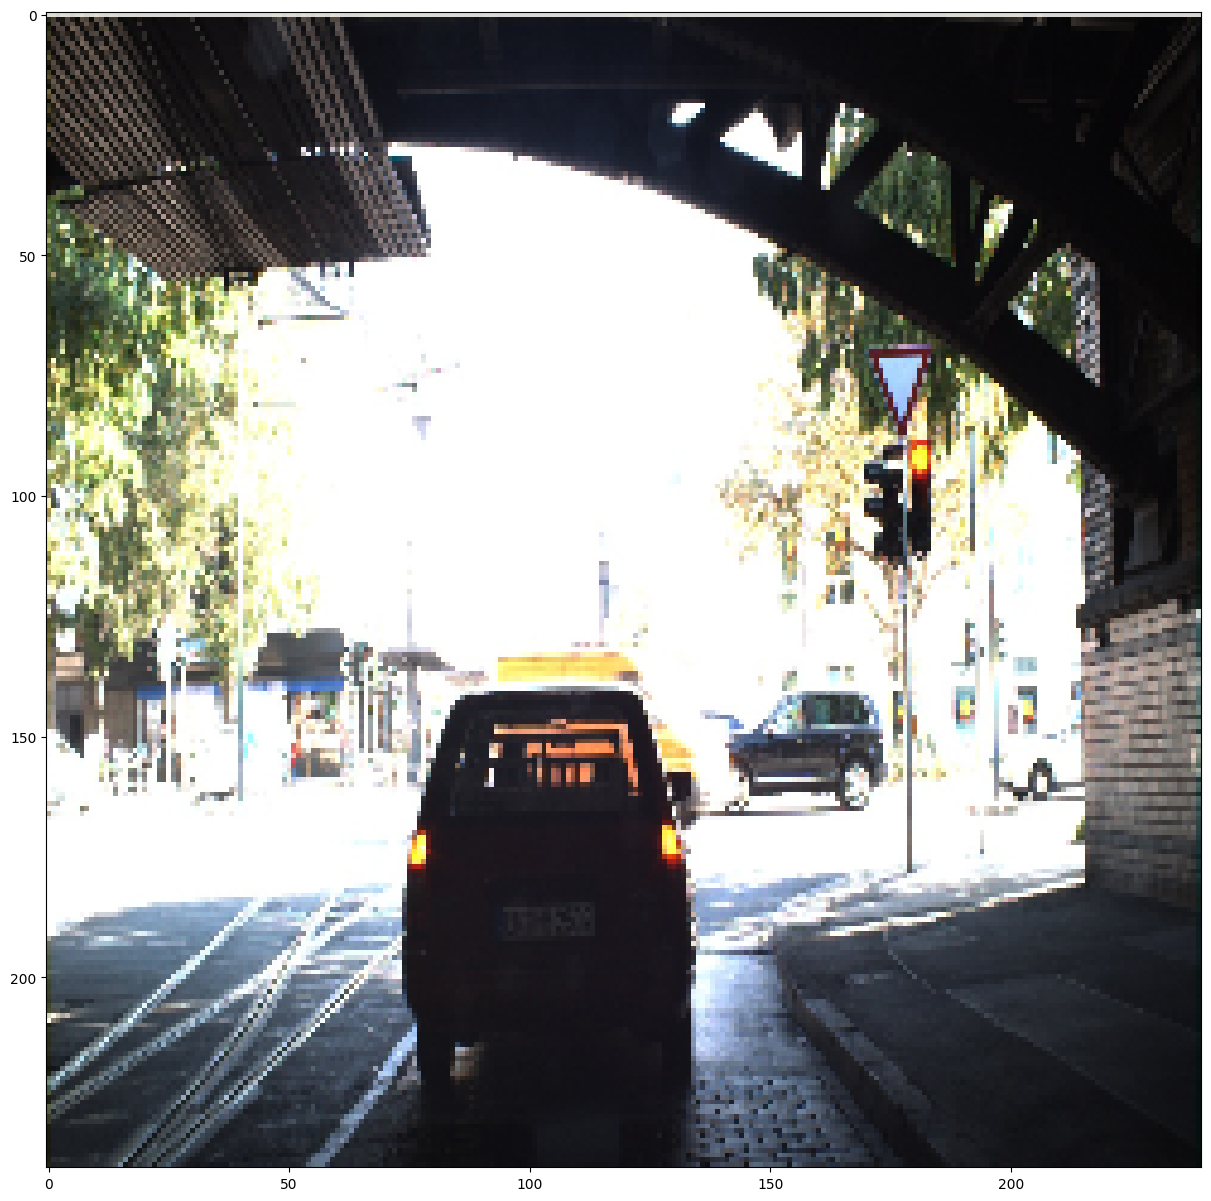

In [6]:
plt.figure(figsize=(15,15))
plt.imshow(image_list[8])
plt.show()

In [7]:
train_data = np.reshape(image_list, (len(image_list), -1))

In [8]:
train_data.shape

(741, 172800)

### Autoencoder Network

In [9]:
with nengo.Network(seed = 0) as auto_net:
    auto_net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([200])
    auto_net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    auto_net.config[nengo.Connection].synapse = None

    n_type = nengo.SpikingRectifiedLinear() 
    n_in = IMG_HEIGHT*IMG_WIDTH*3
    dim_hidden = 512

    input_node = nengo.Node(np.zeros(n_in))

    layer1 = nengo.Ensemble(dim_hidden, 1, neuron_type = n_type)
    nengo.Connection(input_node, layer1.neurons, transform=nengo_dl.dists.Glorot())

    layer2 = nengo.Ensemble(dim_hidden, 1, neuron_type = n_type)
    nengo.Connection(layer1.neurons, layer2.neurons, transform=nengo_dl.dists.Glorot())

    outp = nengo.Ensemble(n_in, 1, neuron_type=n_type)
    nengo.Connection(layer2.neurons, outp.neurons, transform=nengo_dl.dists.Glorot())

    p_c = nengo.Probe(outp.neurons)
    p_c_filt = nengo.Probe(outp.neurons, synapse=0.01, label="out_p_filt")

In [10]:
with nengo_dl.Simulator(network=auto_net, minibatch_size=MINIBATCH_SIZE) as sim:
  sim.predict(np.ones((MINIBATCH_SIZE, 1, n_in)));

Build finished in 0:00:05                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:03                                               
|             Constructing graph: build stage (0%)             | ETA:  --:--:--

/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1003: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  warnings.warn(


1/1 [==============================] - 3s 3s/step


### Train Model

In [11]:
for net_ens in auto_net.all_ensembles:
  net_ens.gain = nengo.dists.Choice([1])
  net_ens.bias = nengo.dists.Choice([0])

In [12]:
for conn in auto_net.all_connections:
  conn.synapse = None 

In [13]:
test_data = train_data

In [14]:
train_data.shape

(741, 172800)

In [15]:
train_data = train_data[:, None, :]

In [16]:
train_data.shape

(741, 1, 172800)

In [17]:
test_data = np.tile(test_data[:, None, :], (1, N_STEPS, 1))

In [18]:
test_data.shape

(741, 10, 172800)

In [19]:
train_data

array([[[245, 255, 253, ...,  27,  50,  55]],

       [[255, 255, 255, ...,  11,  24,  32]],

       [[248, 255, 254, ...,  11,  22,  23]],

       ...,

       [[216, 214, 208, ...,  19,  33,  30]],

       [[223, 221, 207, ...,  75,  83,  67]],

       [[225, 243, 247, ...,   8,  19,  21]]], dtype=uint8)

In [20]:
test_data

array([[[245, 255, 253, ...,  27,  50,  55],
        [245, 255, 253, ...,  27,  50,  55],
        [245, 255, 253, ...,  27,  50,  55],
        ...,
        [245, 255, 253, ...,  27,  50,  55],
        [245, 255, 253, ...,  27,  50,  55],
        [245, 255, 253, ...,  27,  50,  55]],

       [[255, 255, 255, ...,  11,  24,  32],
        [255, 255, 255, ...,  11,  24,  32],
        [255, 255, 255, ...,  11,  24,  32],
        ...,
        [255, 255, 255, ...,  11,  24,  32],
        [255, 255, 255, ...,  11,  24,  32],
        [255, 255, 255, ...,  11,  24,  32]],

       [[248, 255, 254, ...,  11,  22,  23],
        [248, 255, 254, ...,  11,  22,  23],
        [248, 255, 254, ...,  11,  22,  23],
        ...,
        [248, 255, 254, ...,  11,  22,  23],
        [248, 255, 254, ...,  11,  22,  23],
        [248, 255, 254, ...,  11,  22,  23]],

       ...,

       [[216, 214, 208, ...,  19,  33,  30],
        [216, 214, 208, ...,  19,  33,  30],
        [216, 214, 208, ...,  19,  33,  30

In [24]:
with nengo_dl.Simulator(auto_net, minibatch_size=MINIBATCH_SIZE) as sim:
  sim.compile(optimizer = tf.optimizers.RMSprop(1e-5), 
              loss = {p_c: tf.losses.mse,
                      p_c_filt: None}
             ) 
  sim.fit(train_data, train_data, epochs = 10)
  sim.freeze_params(auto_net)
  sim.save_params("./my_saved_params")
  output = sim.predict(test_data[:MINIBATCH_SIZE])

Build finished in 0:00:03                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:02                                               
Epoch 1/10
23/23 [==============================] - 8s 62ms/step - loss: 1723.6571 - probe_loss: 1723.6571
Epoch 2/10
23/23 [==============================] - 1s 60ms/step - loss: 1655.8433 - probe_loss: 1655.8433
Epoch 3/10
23/23 [==============================] - 1s 58ms/step - loss: 1651.9806 - probe_loss: 1651.9806
Epoch 4/10
23/23 [==============================] - 1s 55ms/step - loss: 1651.8135 - probe_loss: 1651.8135
Epoch 5/10
23/23 [==============================] - 1s 54ms/step - loss: 1644.5353 - probe_loss: 1644.5353
Epoch 6/10
23/23 [==============================] - 1s 56ms/step - loss: 1645.5460 - probe_loss: 1645.5460
Epoch 7/10
23/23 [==============================] - 1s 56ms/step - loss: 1643.1062 - probe_loss: 1643.1062
Epoch 8/10


In [25]:
# with nengo_dl.Simulator(auto_net, minibatch_size=MINIBATCH_SIZE) as sim2:
#     sim2.load_params("./my_saved_params")

Build finished in 0:00:02                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:04                                               


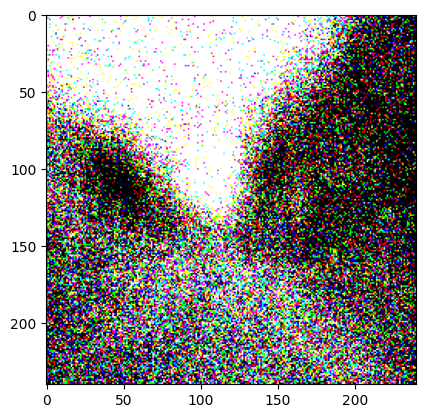

In [26]:
plt.figure()
plt.imshow(output[p_c_filt][0,4].reshape((240, 240, 3)))

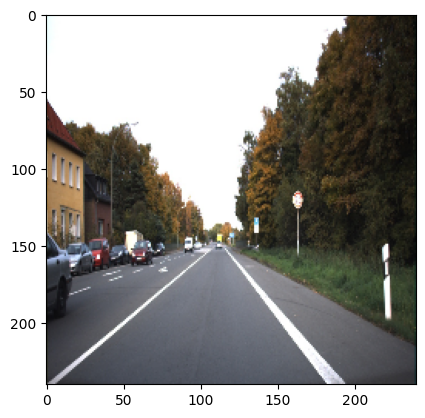

In [27]:
plt.imshow(test_data[0, 4].reshape(240, 240, 3))